*Import library's*

In [1]:
import numpy as np
import pandas as pd
from textblob import TextBlob as tb
import tweepy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob.classifiers import NaiveBayesClassifier
import os, re, nltk, string
from bs4 import BeautifulSoup
from collections import OrderedDict
from operator import itemgetter

*Read data source from csv*

In [2]:
df = pd.read_csv("/Users/gayr/documents/gabriela/mba/tcc/data_sources/nubank_tweets.csv") 
df.head()

,id,created_at,text
0,1093966409577758720,2019-02-08 20:14:51,@Crispapai @nubank Kkkkkkkkkkkkkkkkkkkkkkkkkkk...
1,1093966474216161280,2019-02-08 20:15:07,@Leh_Alvess @nubank SIIM! Depois que chegou o ...
2,1093966632555290626,2019-02-08 20:15:44,O meu roxinho chegou!!! 😍😍😍 👌🏼 #SouNu @nubank ...
3,1093966682585006080,2019-02-08 20:15:56,Meu roxinho chegou! que comece as compras @nu...
4,1093966713987784704,2019-02-08 20:16:04,Queria agradecer a @nubank por ter liberado um...


*Data Cleaning*

In [3]:
def cleanTweets(tweetsDF):
    table = str.maketrans(dict.fromkeys(string.punctuation.replace('@','')))
    # essa regex significa:
    # tudo que conter @ OU http OU terminador de linha seguido de uma palavra OU um espaco OU qualquer outro terminador
    # de linha.
    rePattern1 = '(@|http|\\n)(\w+|\s|\S)'
    formattedTweets = []
    for line in tweetsDF['text']:
        formattedStr = line.lower()
        formattedStr = formattedStr.translate(table)
        formattedStr = re.sub(rePattern1, "", formattedStr)  
        formattedTweets.append(formattedStr)
    return formattedTweets

formattedTweets = cleanTweets(df)
data = pd.DataFrame(formattedTweets, columns=['text'])
data.head()

,text
0,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...
1,siim depois que chegou o meu novo roxinho eu...
2,o meu roxinho chegou 😍😍😍 👌🏼 sounu
3,meu roxinho chegou que comece as compras
4,queria agradecer a por ter liberado um crédit...


*Stopwords in portuguese*

In [4]:
stopwords = nltk.corpus.stopwords.words('portuguese')
# Inclusão de novas stopwords 
stopwords.append('tô')
stopwords.append('tá')
stopwords.append('pra')
stopwords.append('pro')
stopwords.append('é')
stopwords.append('aí')
stopwords.append('ser')
stopwords.append('pq')
stopwords.append('já')
stopwords.append('nao')
stopwords.append('rt')
stopwords.append('porque')
stopwords.append('vai')
stopwords.append('vou')
stopwords.append('faço')
stopwords.append('dm')
stopwords.append('q')
stopwords.append('faz')
stopwords.append('dá')
stopwords.append('assim')
stopwords.append('agora')
stopwords.append('nada')
stopwords.append('tbm')

*WordCloud*

Text(0.5,1,'Tweets WordCloud - atendimento')

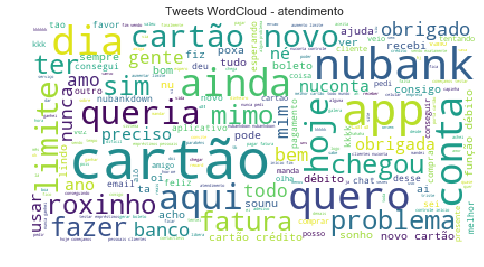

In [5]:
text = " ".join(tweet for tweet in data['text'])
plt.style.use('seaborn')
wordcloud = WordCloud(max_font_size = 50, stopwords = stopwords, background_color = 'white').generate(text)
wordcloud.to_file("nouns_user.png")
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Tweets WordCloud - atendimento')

*Basic statistics about the data*

In [6]:
def word_count(str):
    counts = OrderedDict()
    words = str.split()
    for word in words:
        if word not in stopwords:
            if word in counts:
                counts[word] += 1
            else:
                counts[word] = 1
    return counts

print("There are {} words in the combination of all tweets.".format(len(text)))

counts = sorted(word_count(text).items(), key = itemgetter(1), reverse = True)
display(counts[:10])

There are 356404 words in the combination of all tweets.


[('cartão', 829),
 ('novo', 364),
 ('app', 343),
 ('limite', 276),
 ('nubank', 259),
 ('quero', 218),
 ('conta', 204),
 ('💜', 203),
 ('nuconta', 195),
 ('hoje', 191)]

*Transform occurrences in a dataframe*

In [7]:
wordcount = pd.DataFrame(counts, columns=['word', 'counts'])
top10 = wordcount[:10]
top10

,word,counts
0,cartão,829
1,novo,364
2,app,343
3,limite,276
4,nubank,259
5,quero,218
6,conta,204
7,💜,203
8,nuconta,195
9,hoje,191


*Top 10 most used words*

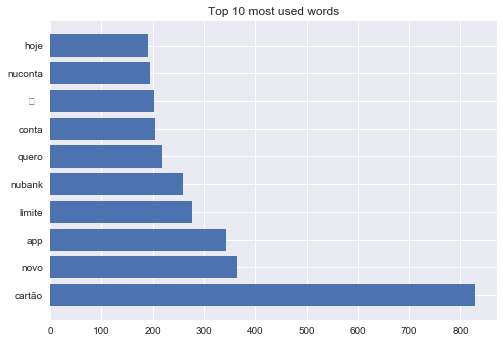

In [8]:
# Dataset
plt.style.use('seaborn')
height = top10.counts
bars = top10.word
y_pos = np.arange(len(bars))
fig = plt.figure()
 
# Create horizontal bars
plt.barh(y_pos, height)

# Create names on the y-axis
plt.yticks(y_pos, bars)

# Create title
plt.title('Top 10 most used words')
 
# Show graphic
plt.show()

In [9]:
# Save graph into a file
fig.savefig('most_used_words.png', bbox_inches='tight', pad_inches=0.1)

*ReLi Lexicon - portuguese sentimental analysis*

In [10]:
base_path = '/Users/gayr/documents/gabriela/mba/tcc/ReLi-Lex'
allData = []
files = [os.path.join(base_path, f) for f in os.listdir(base_path)]
for file in files:
    t = 'pos' if '_Positivos' in file else 'neg'
    with open(file, 'r', encoding = 'latin-1') as content_file:
        content = content_file.read()
        all = re.findall('\[.*?\]',content)
        for w in all:
            allData.append((w[1:-1], t))
allDataDF = pd.DataFrame(allData, columns=['word', 'sentiment'])

*Validate the model and avoid overfit*

Functions

In [11]:
# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# A random forest classifier
from sklearn.ensemble import RandomForestClassifier
# A naive bayes classifier
from sklearn.naive_bayes import MultinomialNB
# A boosting classifier
from sklearn.ensemble import AdaBoostClassifier
# Encode labels with value between 0 and n_classes-1
from sklearn.preprocessing import LabelEncoder
# Accuracy classification score
from sklearn.metrics import accuracy_score
# This classifier is useful as a simple baseline to compare with other (real) classifiers
from sklearn.dummy import DummyClassifier

C:\Users\GAYR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Original Variables

In [12]:
X_original = allDataDF.word
Y_original = allDataDF.sentiment

O sklearn precisa que as variáveis independentes sejam contínuas - por esse motivo precisaremos transformar palavras em números

In [13]:
le_x = LabelEncoder()
X_labelEncoded = le_x.fit_transform(X_original)
le_y = LabelEncoder()
Y_labelEncoded = le_y.fit_transform(Y_original)

In [14]:
zippedEncoded = list(zip(X_labelEncoded, Y_labelEncoded))
dfEncoded = pd.DataFrame(zippedEncoded, columns = ['word', 'sentiment'])

Cross Validation - Divisão da amostra entre treino e teste - scikitlearn

In [15]:
X_labelEncodedDF = dfEncoded.word
Y_labelEncodedDF = dfEncoded.sentiment
X_train, X_test, y_train, y_test = train_test_split(X_labelEncodedDF, Y_labelEncodedDF, test_size=0.30, random_state = 13)

*Classification Models*

Random Forest Classifier

In [16]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train.values.reshape(-1, 1), y_train)
y_pred = rf.predict(X_test.values.reshape(-1, 1))

Naive Bayes Classifier

In [17]:
nb = MultinomialNB()
nb.fit(X_train.values.reshape(-1, 1), y_train)
y_nb_pred = nb.predict(X_test.values.reshape(-1, 1))

Boosting Classifier

In [18]:
clf = AdaBoostClassifier(n_estimators=100)
clf.fit(X_train.values.reshape(-1, 1), y_train)
y_clf_pred = clf.predict(X_test.values.reshape(-1, 1))

Dummy Model

In [19]:
dm = DummyClassifier()
dm.fit(X_train.values.reshape(-1, 1), y_train)
y_dummy_pred = dm.predict(X_test.values.reshape(-1, 1))

*Model´s Accuracy*

In [20]:
print('Accuracy random forest on test dataset: {}'.format(round(accuracy_score(y_test, y_pred), 2)))
print('Accuracy naive bayes on test dataset: {}'.format(round(accuracy_score(y_test, y_nb_pred), 2)))
print('Accuracy boosting on test dataset: {}'.format(round(accuracy_score(y_test, y_clf_pred), 2)))
print('Accuracy dummy model on test dataset: {}'.format(round(accuracy_score(y_test, y_dummy_pred), 2)))

Accuracy random forest on test dataset: 0.68
Accuracy naive bayes on test dataset: 0.62
Accuracy boosting on test dataset: 0.63
Accuracy dummy model on test dataset: 0.52


A seguir, iremos utilizar o algoritmo para classificação Random Forest para a análise de sentimentos, devido ao melhor nível de acurácia apresentado.

In [21]:
# tweetsDataLabelEncoder = LabelEncoder()
tweet_text = data.text
tweetsEncoded = le_x.fit_transform(tweet_text)
y_pred_total = rf.predict(tweetsEncoded.reshape(-1, 1))
y_pred_total_decoded = le_y.inverse_transform(y_pred_total)
data['sentiment'] = y_pred_total_decoded
display(data[:10])

C:\Users\GAYR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,text,sentiment
0,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,pos
1,siim depois que chegou o meu novo roxinho eu...,pos
2,o meu roxinho chegou 😍😍😍 👌🏼 sounu,pos
3,meu roxinho chegou que comece as compras,pos
4,queria agradecer a por ter liberado um crédit...,pos
5,,pos
6,já pedi e foi rejeitado tô só fazendo drama m...,pos
7,tudo bem e vc pesquisa um nome no histórico d...,pos
8,às vezes agradeço por ter o aumento negado p...,pos
9,como não amar 👌🏽💜,pos


*Counting positives and negatives*

In [22]:
df = data.groupby('sentiment').count()
df

,text
sentiment,
neg,293
pos,5605


*Sentimental Analysis Graph based on Naive-Bayes Classification*

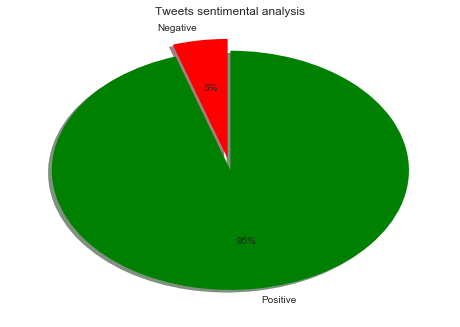

In [23]:
plt.style.use('seaborn')
pie_pos = df.loc['pos']
pie_neg = df.loc['neg']
fig = plt.figure()

slices = [pie_neg, pie_pos]
tweets = ['Negative', 'Positive']
columns = ['Red', 'Green']

plt.title('Tweets sentimental analysis')
 
plt.pie(slices, labels = tweets, colors = columns, startangle = 90, shadow = True, explode = (0.1, 0), autopct='%1.0f%%')

plt.show()

In [24]:
# Save graph into a file
fig.savefig("tweets_sentimental_analysis.png")

*Positive WordCloud*

In [25]:
# filtrar dataframe com tweets positivos
data_pos_filtered = data[data['sentiment'] == 'pos']
data_pos_filtered.head()

,text,sentiment
0,kkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkkk...,pos
1,siim depois que chegou o meu novo roxinho eu...,pos
2,o meu roxinho chegou 😍😍😍 👌🏼 sounu,pos
3,meu roxinho chegou que comece as compras,pos
4,queria agradecer a por ter liberado um crédit...,pos


*Save positive tweets in a csv file*

In [26]:
data_pos_filtered.to_csv("positive_tweets.csv", index = False, sep=';', encoding='utf-16')

*Like mask*

In [27]:
from PIL import Image
like_mask = np.array(Image.open("c:/Users/GAYR/Documents/Gabriela/MBA/tcc/images/like.png"))
like_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

*Transform the mask*

In [28]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [29]:
# Transform your mask into a new one that will work with the function:
transformed_like_mask = np.ndarray((like_mask.shape[0],like_mask.shape[1]), np.int32)

for i in range(len(like_mask)):
    transformed_like_mask[i] = list(map(transform_format, like_mask[i]))

In [30]:
# Check the expected result of your mask
transformed_like_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [31]:
# Create a word cloud image
wc = WordCloud(background_color="white", max_words=1000, mask=transformed_like_mask,
               stopwords=stopwords, contour_width=1, contour_color='white')

Text(0.5,1,'Positive Tweets WordCloud')

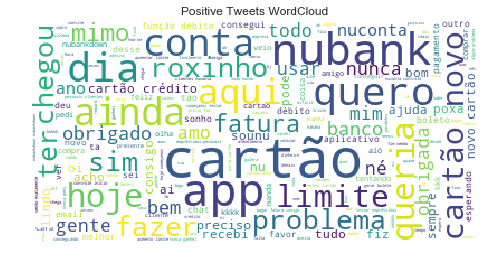

In [32]:
# WordCloud
plt.style.use('seaborn')
data_pos_filtered = " ".join(tweet for tweet in data_pos_filtered['text'])
wordcloud = WordCloud(max_font_size = 50, stopwords = stopwords, background_color = 'white').generate(text)
wordcloud.to_file("nouns_user_pos.png")
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Positive Tweets WordCloud')

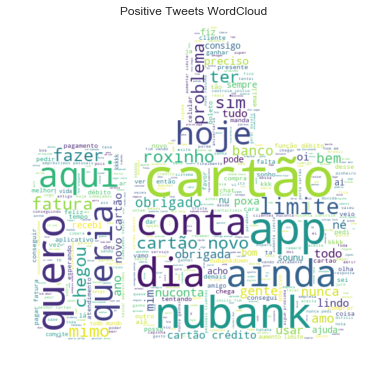

In [33]:
# Generate a wordcloud
wc.generate(text)

# store to file
wc.to_file("c:/Users/GAYR/Documents/Gabriela/MBA/tcc/images/likecloud.png")

# show
plt.figure(figsize=[15,6])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Tweets WordCloud')
plt.show()

*Top 10 most used words in positive tweets*

In [34]:
count_pos = sorted(word_count(data_pos_filtered).items(), key = itemgetter(1), reverse = True)
wordcount_pos = pd.DataFrame(count_pos, columns=['word', 'counts'])
top10_pos = wordcount_pos[:10]
top10_pos

,word,counts
0,cartão,806
1,novo,357
2,app,338
3,limite,266
4,nubank,247
5,quero,204
6,💜,201
7,conta,197
8,nuconta,191
9,hoje,185


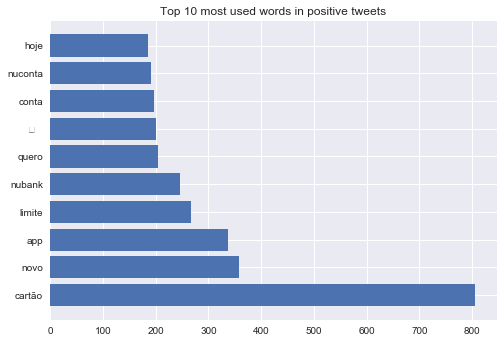

In [35]:
# Dataset
plt.style.use('seaborn')
height = top10_pos.counts
bars = top10_pos.word
y_pos = np.arange(len(bars))
fig = plt.figure()
 
# Create horizontal bars
plt.barh(y_pos, height)

# Create names on the y-axis
plt.yticks(y_pos, bars)

# Create title
plt.title('Top 10 most used words in positive tweets')
 
# Show graphic
plt.show()

In [36]:
# Save graph into a file
fig.savefig("most_used_positive_words.png")

*Negative WordCloud*

In [37]:
# filtrar dataframe com tweets positivos
data_neg_filtered = data[data['sentiment'] == 'neg']
data_neg_filtered.head()

,text,sentiment
37,n aguento mais me humilhar ok,neg
81,aceito de presente 😘,neg
98,pelo visto teve com o santander xd,neg
109,a quero muito e ao mesmo tempo não kkkkk,neg
153,cobriu o nome aqui mas lá em cima tá mostra...,neg


*Save negative tweets in a csv file*

In [38]:
data_neg_filtered.to_csv("negative_tweets.csv", index = False, sep=';', encoding='utf-16')

*Dislike mask*

In [39]:
from PIL import Image
dislike_mask = np.array(Image.open("c:/Users/GAYR/Documents/Gabriela/MBA/tcc/images/dislike.png"))
dislike_mask

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

*Transform the mask*

In [40]:
def transform_format(val):
    if val == 1:
        return 255
    else:
        return val

In [41]:
# Transform your mask into a new one that will work with the function:
transformed_dislike_mask = np.ndarray((dislike_mask.shape[0],dislike_mask.shape[1]), np.int32)

for i in range(len(dislike_mask)):
    transformed_dislike_mask[i] = list(map(transform_format, dislike_mask[i]))

In [42]:
# Check the expected result of your mask
transformed_dislike_mask

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]])

In [43]:
# Create a word cloud image
wc_dislike = WordCloud(background_color="white", max_words=1000, mask=transformed_dislike_mask,
               stopwords=stopwords, contour_width=1, contour_color='white')

Text(0.5,1,'Negative Tweets WordCloud')

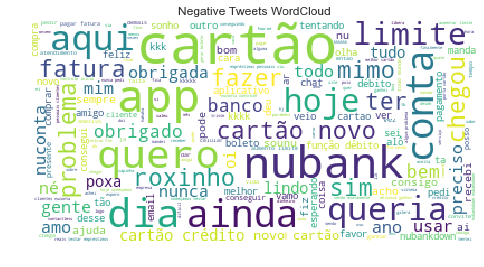

In [44]:
# WordCloud
plt.style.use('seaborn')
data_neg_filtered = " ".join(tweet for tweet in data_neg_filtered['text'])
wordcloud = WordCloud(max_font_size = 50, stopwords = stopwords, background_color = 'white').generate(text)
wordcloud.to_file("nouns_user_neg.png")
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Negative Tweets WordCloud')

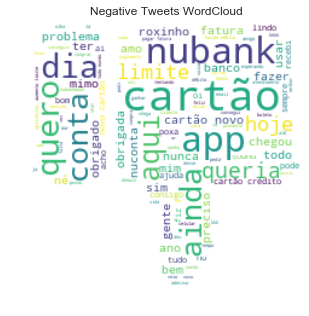

In [45]:
# Generate a wordcloud
wc_dislike.generate(text)

# store to file
wc_dislike.to_file("c:/Users/GAYR/Documents/Gabriela/MBA/tcc/images/dislikecloud.png")

# show
plt.figure(figsize=[12,5])
plt.imshow(wc_dislike, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Tweets WordCloud')
plt.show()

*Top 10 most used words in negative tweets*

In [46]:
count_neg = sorted(word_count(data_neg_filtered).items(), key = itemgetter(1), reverse = True)
wordcount_neg = pd.DataFrame(count_neg, columns=['word', 'counts'])
top10_neg = wordcount_neg[:10]
top10_neg

,word,counts
0,cartão,23
1,nubankdown,15
2,quero,14
3,ainda,14
4,nubank,12
5,limite,10
6,nunca,9
7,sim,8
8,crédito,8
9,uso,8


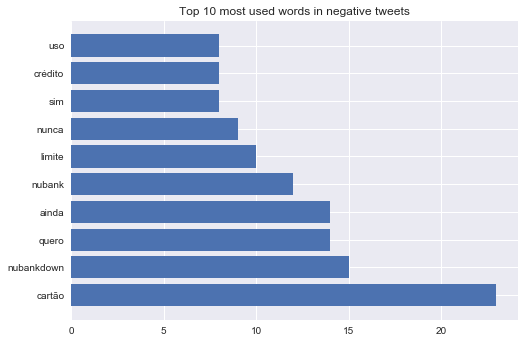

In [47]:
# Dataset
plt.style.use('seaborn')
height = top10_neg.counts
bars = top10_neg.word
y_pos = np.arange(len(bars))
fig = plt.figure()
 
# Create horizontal bars
plt.barh(y_pos, height)

# Create names on the y-axis
plt.yticks(y_pos, bars)

# Create title
plt.title('Top 10 most used words in negative tweets')
 
# Show graphic
plt.show()

In [48]:
# Save into a file
fig.savefig("most_used_negative_words.png")